In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, inspect, sys
from sksurv.ensemble import RandomSurvivalForest
from sksurv.datasets import load_gbsg2
import sksurv
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_3 as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib_3' from '/Users/apple/Desktop/s2ds/work_project/Oct20_EPRI/Task3/NB/epri_mc_lib_3.py'>

In [144]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

sns.set_style("whitegrid")

In [145]:
real_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/Survival_df.csv'),
                  index_col=0)

In [146]:
data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/CopulaGAN_simulated_data_survival.csv'),
                  index_col=0)
data.reset_index(inplace=True)

## Seperating input and output

#### Real Data

In [147]:
real_x = real_data.iloc[:, 2:]
real_x # The real data input

,NDE_cycle,diff_two_peaks_ratio,amp_ratio,pos_ratio,energy_ratio,NLE_ratio_51_17,NLE_ratio_85_17,NLE_ratio_119_17,NLO_avg,Avg_RP,ACEE_30_Avg_58,ACEE_500_Avg_58,ACPD_Avg_58
ID,,,,,,,,,,,,,
41C,0,2.104871,1.185236,1.002988,1.559453,0.893268,1.107898,0.462483,5.576476,190.979294,-0.137640,-2.866030,4.804749
44C,0,2.280959,1.365329,0.998446,1.504218,0.888503,1.140535,0.477160,4.619563,187.204261,-0.596385,-2.788500,3.370729
45C,0,1.245687,0.809970,0.989351,1.282046,0.896534,1.137561,0.491483,3.458337,189.010633,-0.645710,-3.202220,4.186639
19C,450000,0.763296,1.128928,1.002407,1.126849,0.978877,1.235508,0.530102,3.798736,171.925123,-1.065155,-1.570740,3.226957
32C,450000,0.610771,1.137713,0.994283,0.844962,0.844824,1.091099,0.459167,4.296261,169.717689,-0.617190,-1.312415,2.907922
23C,600000,0.397580,0.919473,0.999861,0.846653,0.918699,1.114762,0.495867,5.621833,173.403495,-0.831110,-1.194540,3.061743
25C,600000,0.821445,1.178319,1.003158,1.141313,0.881052,1.083718,0.477500,3.061693,172.727399,-0.912065,-0.927155,3.284087
21C,600000,0.705402,1.151889,0.984968,0.853808,0.929446,1.119635,0.493245,4.626314,174.003954,-0.884900,-1.578795,2.764862
27C,750000,0.144147,0.777585,1.002966,0.394731,0.912962,1.112708,0.500035,5.020607,173.688949,-1.276355,-1.602150,2.746634


#### Scaling real data

In [148]:
sc_real_x = mc.scale_general(real_x, MinMaxScaler())[0]
sc_real_x.index = real_x.index

In [149]:
sc_real_x

,NDE_cycle,diff_two_peaks_ratio,amp_ratio,pos_ratio,energy_ratio,NLE_ratio_51_17,NLE_ratio_85_17,NLE_ratio_119_17,NLO_avg,Avg_RP,ACEE_30_Avg_58,ACEE_500_Avg_58,ACPD_Avg_58
ID,,,,,,,,,,,,,
41C,0.000000,0.917593,0.746081,0.617935,1.000000,0.361383,0.356725,0.308942,0.523859,1.000000,1.000000,0.147772,1.000000
44C,0.000000,1.000000,1.000000,0.477711,0.952577,0.325834,0.521246,0.458945,0.324522,0.822448,0.597138,0.181850,0.409761
45C,0.000000,0.515506,0.216983,0.196920,0.761826,0.385745,0.506255,0.605323,0.082626,0.907408,0.553822,0.000000,0.745587
19C,0.500000,0.289753,0.666691,0.600024,0.628578,1.000000,1.000000,1.000000,0.153535,0.103823,0.185472,0.717114,0.350584
32C,0.500000,0.218374,0.679078,0.349186,0.386556,0.000000,0.272039,0.275051,0.257175,0.000000,0.578867,0.830660,0.219270
23C,0.666667,0.118603,0.371374,0.521407,0.388009,0.551092,0.391323,0.650125,0.533307,0.173355,0.391007,0.882471,0.282582
25C,0.666667,0.316966,0.736329,0.623196,0.640996,0.270250,0.234833,0.462413,0.000000,0.141556,0.319913,1.000000,0.374099
21C,0.666667,0.262660,0.699064,0.061617,0.394152,0.631258,0.415889,0.623331,0.325929,0.201596,0.343769,0.713573,0.160387
27C,0.833333,0.000000,0.171322,0.617270,0.000000,0.508295,0.380970,0.692719,0.408065,0.186781,0.000000,0.703307,0.152884


#### Simulated  (Copula GAN)

In [150]:
data_x = data.iloc[:, 2:]
data_x # The simulated input data

,NDE_cyle,diff_two_peaks_ratio,amp_ratio,pos_ratio,energy_ratio,NLE_ratio_51_17,NLE_ratio_85_17,NLE_ratio_119_17,NLO_avg,Avg_RP,ACEE_30_Avg_58,ACEE_500_Avg_58,ACPD_Avg_58
0,600000,0.529909,1.091504,0.993960,0.848464,0.917375,1.112056,0.505540,5.432829,174.266786,-0.847639,-1.340496,3.276437
1,750000,0.196585,0.849821,0.994489,0.505600,0.910996,1.116821,0.497770,6.898934,171.325300,-0.893297,-1.712179,3.106521
2,900000,0.384845,1.077153,1.000971,0.708655,0.878908,1.130553,0.487624,3.948716,170.217690,-0.764145,-1.190668,2.559568
3,0,2.474125,1.338242,0.995126,1.308626,0.895148,1.132818,0.487866,6.884989,188.904421,-0.476904,-2.805754,4.676679
4,900000,0.437564,1.039553,1.007743,0.721039,0.894121,1.163510,0.495600,5.466000,171.473636,-0.947583,-1.325563,2.553673
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,3.131660,1.327767,1.006446,2.672155,0.870106,1.126553,0.461652,5.341247,198.007746,-0.318230,-2.101181,4.278491
996,900000,0.312099,1.255932,0.997464,0.679803,0.887969,1.112964,0.491979,4.663054,171.740833,-0.806248,-1.186281,2.851250
997,900000,0.595612,1.167238,1.000232,0.856687,0.891326,1.148279,0.491675,4.363576,172.275905,-0.880523,-1.327719,3.104035
998,450000,1.486775,1.269441,0.996086,1.009475,0.912585,1.178257,0.488794,4.098630,170.058396,-0.918933,-1.237451,3.339072


#### Scaling the simulated data

In [151]:
sc_data_x = mc.scale_general(data_x, MinMaxScaler())[0]
sc_data_x.index = data_x.index

In [152]:
sc_data_x

,NDE_cyle,diff_two_peaks_ratio,amp_ratio,pos_ratio,energy_ratio,NLE_ratio_51_17,NLE_ratio_85_17,NLE_ratio_119_17,NLO_avg,Avg_RP,ACEE_30_Avg_58,ACEE_500_Avg_58,ACPD_Avg_58
0,0.666667,0.019988,0.458774,0.418539,0.168169,0.547201,0.425623,0.682826,0.493935,1.150497e-01,0.367512,0.752113,0.315955
1,0.833333,0.002833,0.209575,0.430938,0.041214,0.524289,0.436243,0.674356,0.799342,4.065755e-02,0.339259,0.626605,0.265780
2,1.000000,0.012522,0.443977,0.582976,0.116401,0.409019,0.466849,0.663297,0.184777,1.264535e-02,0.419177,0.802706,0.104271
3,0.000000,0.120054,0.713186,0.445882,0.338558,0.467357,0.471897,0.663561,0.796437,4.852453e-01,0.596917,0.257332,0.729433
4,1.000000,0.015236,0.405208,0.741823,0.120986,0.463670,0.540303,0.671991,0.500845,4.440906e-02,0.305668,0.757156,0.102530
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000000,0.153896,0.702385,0.711405,0.843447,0.377402,0.457933,0.634987,0.474858,7.154745e-01,0.695103,0.495249,0.611852
996,1.000000,0.008778,0.628316,0.500725,0.105718,0.441568,0.427645,0.668044,0.333582,5.116665e-02,0.393124,0.804187,0.190401
997,1.000000,0.023370,0.536863,0.565645,0.171214,0.453628,0.506356,0.667713,0.271197,6.469898e-02,0.347164,0.756427,0.265046
998,0.500000,0.069237,0.642246,0.468402,0.227789,0.529996,0.573173,0.664572,0.216006,8.616708e-03,0.323397,0.786909,0.334451


#### Output of the real data

In [153]:
real_y = real_data.iloc[:, 0:2]
real_y # The real data output

,Observed,F_Time
ID,,
41C,True,2154137.0
44C,True,1318034.0
45C,False,3245267.0
19C,True,464392.0
32C,True,306142.0
23C,False,2255225.0
25C,False,1444844.0
21C,True,200007.0
27C,True,297627.0


In [154]:
data_y = data.iloc[:, 0:2]
data_y # simulated data output

,Observed,F_Time
0,False,1.751191e+06
1,False,8.805501e+05
2,True,3.848121e+05
3,True,1.194672e+06
4,True,7.445108e+05
...,...,...
995,False,3.035034e+06
996,True,6.093648e+05
997,True,3.989339e+05
998,True,3.731964e+05


### Creating Test, Train data

In [155]:
# This is for the simulated data
X_train, X_test, y_train, y_test = train_test_split(sc_data_x, data_y, test_size=0.3)

In [156]:
y_test

,Observed,F_Time
697,True,6.094640e+05
565,False,2.053994e+06
470,True,5.886850e+05
130,False,3.128316e+06
681,True,3.836127e+05
...,...,...
718,True,2.727629e+05
168,True,5.594291e+05
576,True,3.199608e+05
329,True,2.888847e+06


In [157]:
## Formatting y dataset for the survival ananlysis
data_y_num=data_y.to_records(index=False)
real_y_num=real_y.to_records(index=False)
y_train_num = y_train.to_records(index=False)
y_test_num = y_test.to_records(index=False)

In [158]:
real_y_num

rec.array([( True, 2154137.), ( True, 1318034.), (False, 3245267.),
           ( True,  464392.), ( True,  306142.), (False, 2255225.),
           (False, 1444844.), ( True,  200007.), ( True,  297627.),
           (False, 2829121.), (False, 1537912.), (False, 1266052.),
           ( True,  514878.), (False, 2101992.), ( True,  603724.),
           (False, 2143805.)],
          dtype=[('Observed', '?'), ('F_Time', '<f8')])

### SVM Survival Model

This guide demonstrates how to use the efficient implementation of Survival Support Vector Machines, which is an extension of the standard Support Vector Machine to right-censored time-to-event data. Its main advantage is that it can account for complex, non-linear relationships between features and survival via the so-called kernel trick. A kernel function implicitly maps the input features into high-dimensional feature spaces where survival can be described by a hyperplane. This makes Survival Support Vector Machines extremely versatile and applicable to a wide a range of data. A popular example for such a kernel function is the Radial Basis Function.

Survival analysis in the context of Support Vector Machines can be described in two different ways:

As a ranking problem: the model learns to assign samples with shorter survival times a lower rank by considering all possible pairs of samples in the training data.

As a regression problem: the model learns to directly predict the (log) survival time.

In both cases, the disadvantage is that predictions cannot be easily related to standard quantities in survival analysis, namely survival function and cumulative hazard function. Moreover, they have to retain a copy of the training data to do predictions.

Let’s start by taking a closer look at the Linear Survival Support Vector Machine, which does not allow selecting a specific kernel function, but can be fitted faster than the more generic Kernel Survival Support Vector Machine.

In [159]:
data_y_num.shape[0] # Total number of records

1000

In [160]:
data_y_num["Observed"].sum() # Number of uncensored data

514

In [161]:
# Finding the % of the censored data
n_censored = data_y_num.shape[0] - data_y_num["Observed"].sum()
print("%.1f%% of records are censored" % (n_censored / data_y_num.shape[0] * 100))

48.6% of records are censored


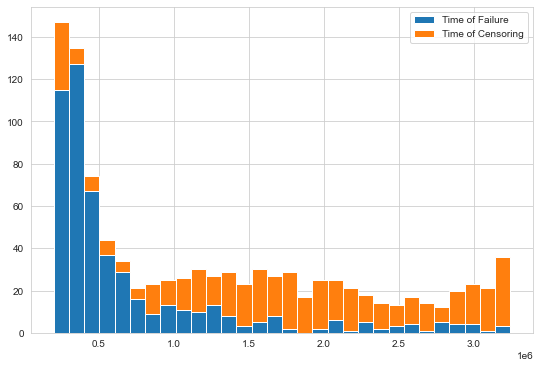

In [162]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist((data_y_num["F_Time"][data_y_num["Observed"]],
                               data_y_num["F_Time"][~data_y_num["Observed"]]),
                              bins=30, stacked=True)
_ = plt.legend(patches, ["Time of Failure", "Time of Censoring"])

In [163]:
# Model Inititation
estimator = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=2020)

In [164]:
def score_survival_model(model, X, y):
    '''
    returns Harrell’s concordance index for the given estimator, X and y
    
    '''
#    model.fit(X_train, y_train_num)
    prediction = model.predict(X)
    result = concordance_index_censored(y['Observed'], y['F_Time'], prediction)
    return result[0]

In [165]:
#score_survival_model(estimator, data_x, data_y_num)

The hyper-parameter 𝛼>0 determines the amount of regularization to apply: a smaller value increases the amount of regularization and a higher value reduces the amount of regularization. The hyper-parameter 𝑟∈[0;1] determines the trade-off between the ranking objective and the regression objective. If 𝑟=1 it reduces to the ranking objective, and if 𝑟=0 to the regression objective. If the regression objective is used, it is advised to log-transform the observed time first.

In [166]:
param_grid = {'alpha': 2. ** np.arange(-12, 13, 2)}
cv = ShuffleSplit(n_splits=100, test_size=0.5, random_state=2020)
gcv = GridSearchCV(estimator, param_grid, scoring=score_survival_model,
                   n_jobs=4, iid=False, refit=False,
                   cv=cv)

In [167]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
gcv = gcv.fit(sc_data_x, data_y_num)

In [168]:
round(gcv.best_score_, 3), gcv.best_params_

(0.863, {'alpha': 4096.0})

In [169]:
def plot_performance(gcv):
    '''
    Plots the performance of the Grid Search for each alpha
    
    '''
    n_splits = gcv.cv.n_splits
    cv_scores = {"alpha": [], "test_score": [], "split": []}
    order = []
    for i, params in enumerate(gcv.cv_results_["params"]):
        name = "%.5f" % params["alpha"]
        order.append(name)
        for j in range(n_splits):
            vs = gcv.cv_results_["split%d_test_score" % j][i]
            cv_scores["alpha"].append(name)
            cv_scores["test_score"].append(vs)
            cv_scores["split"].append(j)
    df = pandas.DataFrame.from_dict(cv_scores)
    _, ax = plt.subplots(figsize=(11, 6))
    sns.boxplot(x="alpha", y="test_score", data=df, order=order, ax=ax)
    _, xtext = plt.xticks()
    for t in xtext:
        t.set_rotation("vertical")

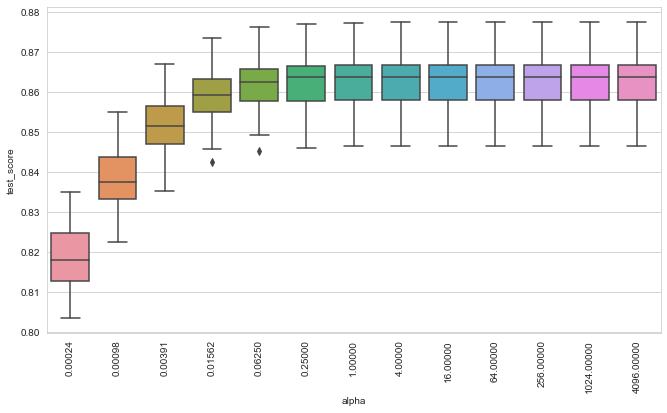

In [170]:
plot_performance(gcv)

It seems that the change in the alpha value has no effect.

In [171]:
# The best alpha value obtained from the Grid Search
estimator.set_params(**gcv.best_params_)
estimator.fit(sc_data_x, data_y_num)

FastSurvivalSVM(alpha=4096.0, fit_intercept=False, max_iter=1000,
                optimizer='avltree', random_state=2020, rank_ratio=1.0,
                timeit=False, tol=1e-05, verbose=False)

It is important to remember that only if the ranking objective is used exclusively (𝑟=1), that predictions denote risk scores, i.e. a higher predicted value indicates shorter survival, a lower value longer survival.

In [172]:
pred = estimator.predict(sc_data_x.iloc[:2])
print(np.round(pred, 3))
print(data_y_num[:2])

[-3.28  -3.098]
[(False, 1751190.50522918) (False,  880550.09729469)]


The model predicted that the first sample has a lower risk than the second sample, which is in concordance with the actual survival times.

### Implementing on the real data

In [173]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
gcv = gcv.fit(sc_data_x, data_y_num)

In [174]:
round(gcv.best_score_, 3), gcv.best_params_

(0.863, {'alpha': 4096.0})

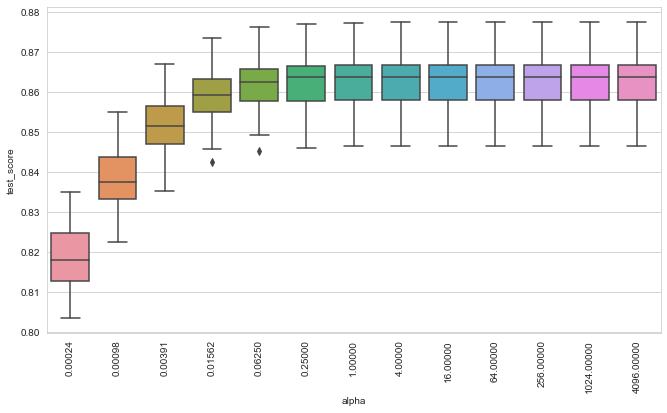

In [175]:
plot_performance(gcv)

In [176]:
# The best alpha value obtained from the Grid Search
estimator.set_params(**gcv.best_params_)
estimator.fit(sc_real_x, real_y_num)

FastSurvivalSVM(alpha=4096.0, fit_intercept=False, max_iter=1000,
                optimizer='avltree', random_state=2020, rank_ratio=1.0,
                timeit=False, tol=1e-05, verbose=False)

In [177]:
pred = estimator.predict(sc_real_x)
print(np.round(pred, 3))
print(real_y_num)

[ -7.599  -6.639  -8.568  -3.908  -2.991  -8.568  -8.107  -1.063  -2.047
  -8.573  -7.623 -13.698  -4.815  -9.195  -5.724  -7.663]
[( True, 2154137.) ( True, 1318034.) (False, 3245267.) ( True,  464392.)
 ( True,  306142.) (False, 2255225.) (False, 1444844.) ( True,  200007.)
 ( True,  297627.) (False, 2829121.) (False, 1537912.) (False, 1266052.)
 ( True,  514878.) (False, 2101992.) ( True,  603724.) (False, 2143805.)]


### Regression

If the regression objective is used (𝑟<1), the semantics are different, because now predictions are on the time scale and lower predicted values indicate shorter survival, higher values longer survival. Moreover, we saw from the histogram of observed times above that the distribution is skewed, therefore it is advised to log-transform the observed time before fitting a model. Here, we are going to use the transformation 𝑦′=log(1+𝑦).

In [187]:
y_log_t = data_y_num.copy()
y_log_t["F_Time"]= np.log1p(data_y_num["F_Time"])

Let’s fit a model using the regression objective (𝑟=0) and compare its performance to the ranking model from above.

In [189]:
ref_estimator = FastSurvivalSVM(rank_ratio=0.0, max_iter=1000, tol=1e-5, random_state=2020)
ref_estimator.fit(sc_data_x, y_log_t)

cindex = concordance_index_censored(
    data_y_num['Observed'],
    data_y_num['F_Time'],
    -ref_estimator.predict(sc_data_x),  # flip sign to obtain risk scores
)
print(round(cindex[0], 3))

0.711


Note that concordance_index_censored expects risk scores, therefore, we had to flip the sign of predictions. The resulting performance of the regression model is comparable to the of the ranking model above.

In [192]:
pred_log = ref_estimator.predict(sc_real_x)
pred_y = np.expm1(pred_log)
print(np.round(pred_y, 3))

[1.16711659e+06 3.88469000e+03 6.35875890e+04 6.36473670e+08
 6.09965000e+02 9.62808200e+06 3.35546670e+04 1.00079480e+05
 3.05883320e+04 3.39121618e+07 1.58878000e+02 6.46063450e+04
 2.69761460e+04 1.58785741e+05 9.18892049e+05 1.01536238e+06]


In [181]:
#from sksurv.kernels import clinical_kernel
#from sksurv.svm import FastKernelSurvivalSVM

In [182]:
#kernel_matrix = clinical_kernel(data_x)

In [183]:
#kssvm = FastKernelSurvivalSVM(optimizer="rbtree", kernel="precomputed", random_state=2020)
#
#kgcv = GridSearchCV(kssvm, param_grid, scoring=score_survival_model,
#                    n_jobs=4, iid=False, refit=False,
#                    cv=cv)

In [184]:
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)
#kgcv = kgcv.fit(kernel_matrix, data_y_num)

In [185]:
#round(kgcv.best_score_, 3), kgcv.best_params_

In [186]:
#plot_performance(kgcv)